#### * Step 1: Package import and mode save path

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBRegressor, XGBClassifier
import joblib
import warnings
warnings.filterwarnings("ignore")


In [3]:
import os
MODEL_DIR = "./forecast_model"
os.makedirs(MODEL_DIR, exist_ok=True)

#### * Step 2:Loading Data

In [5]:
# Load your CSV data
df = pd.read_csv("data-1753054598583.csv")

# Preview
df.head()


,site_code,site_name,site_type,latitude,longitude,datetime,day_of_week,aqi,co,no,...,dew_point,uvi,clouds,visibility,wind_speed,wind_deg,weather_main,weather_description,traffic_flow,traffic_density
0,VS1,Westminster - Victoria Street,Kerbside,51.499245,-0.131285,2024-07-11 00:00:00,4,1,153.54,0.0,...,285.35,NaN,75,10000.0,4.63,240,Clouds,broken clouds,low,high
1,WME,Westminster - Queens Park Gardens,Urban Background,51.528663,-0.208754,2024-07-11 00:00:00,4,1,156.88,0.0,...,285.82,NaN,40,10000.0,4.63,260,Clouds,scattered clouds,low,high
2,VS1,Westminster - Victoria Street,Kerbside,51.499245,-0.131285,2024-07-11 01:00:00,4,1,151.87,0.0,...,285.40,NaN,75,10000.0,5.14,240,Clouds,broken clouds,low,high
3,WME,Westminster - Queens Park Gardens,Urban Background,51.528663,-0.208754,2024-07-11 01:00:00,4,1,156.88,0.0,...,285.75,NaN,100,10000.0,5.14,240,Clouds,overcast clouds,low,high
4,VS1,Westminster - Victoria Street,Kerbside,51.499245,-0.131285,2024-07-11 02:00:00,4,1,151.87,0.0,...,285.48,NaN,100,10000.0,5.14,240,Clouds,overcast clouds,low,high


#### * Step 3: Data Cleaning and Sorting based on dates

In [7]:
# Convert datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Map textual traffic columns to ordinal integers
df['traffic_flow'] = df['traffic_flow'].str.strip().str.lower().map({'low': 0, 'moderate_low': 1, 'moderate': 2, 'moderate_high': 3, 'high': 4 })
df['traffic_density'] = df['traffic_density'].str.strip().str.lower().map({'low': 0, 'moderate_low': 1, 'moderate': 2, 'moderate_high': 3, 'high': 4 })

# Sort by datetime and then site_code
df = df.sort_values(by=['datetime', 'site_code']).reset_index(drop=True)

# Check
df[['datetime', 'site_code', 'traffic_flow', 'traffic_density']].head()


,datetime,site_code,traffic_flow,traffic_density
0,2024-07-11 00:00:00,VS1,0,4
1,2024-07-11 00:00:00,WME,0,4
2,2024-07-11 01:00:00,VS1,0,4
3,2024-07-11 01:00:00,WME,0,4
4,2024-07-11 02:00:00,VS1,0,4


#### * Step 4: Exploratory Data Analysis (EDA)

site_code                   0
site_name                   0
site_type                   0
latitude                    0
longitude                   0
datetime                    0
day_of_week                 0
aqi                         0
co                          0
no                          0
no2                         0
o3                          0
so2                         0
pm2_5                       0
pm10                        0
nh3                         0
temp                        0
feels_like                  0
pressure                    0
humidity                    0
dew_point                   0
uvi                    174894
clouds                      0
visibility              16933
wind_speed                  0
wind_deg                    0
weather_main                0
weather_description         0
traffic_flow                0
traffic_density             0
dtype: int64
site_code              0
site_name              0
site_type              0
latitude    

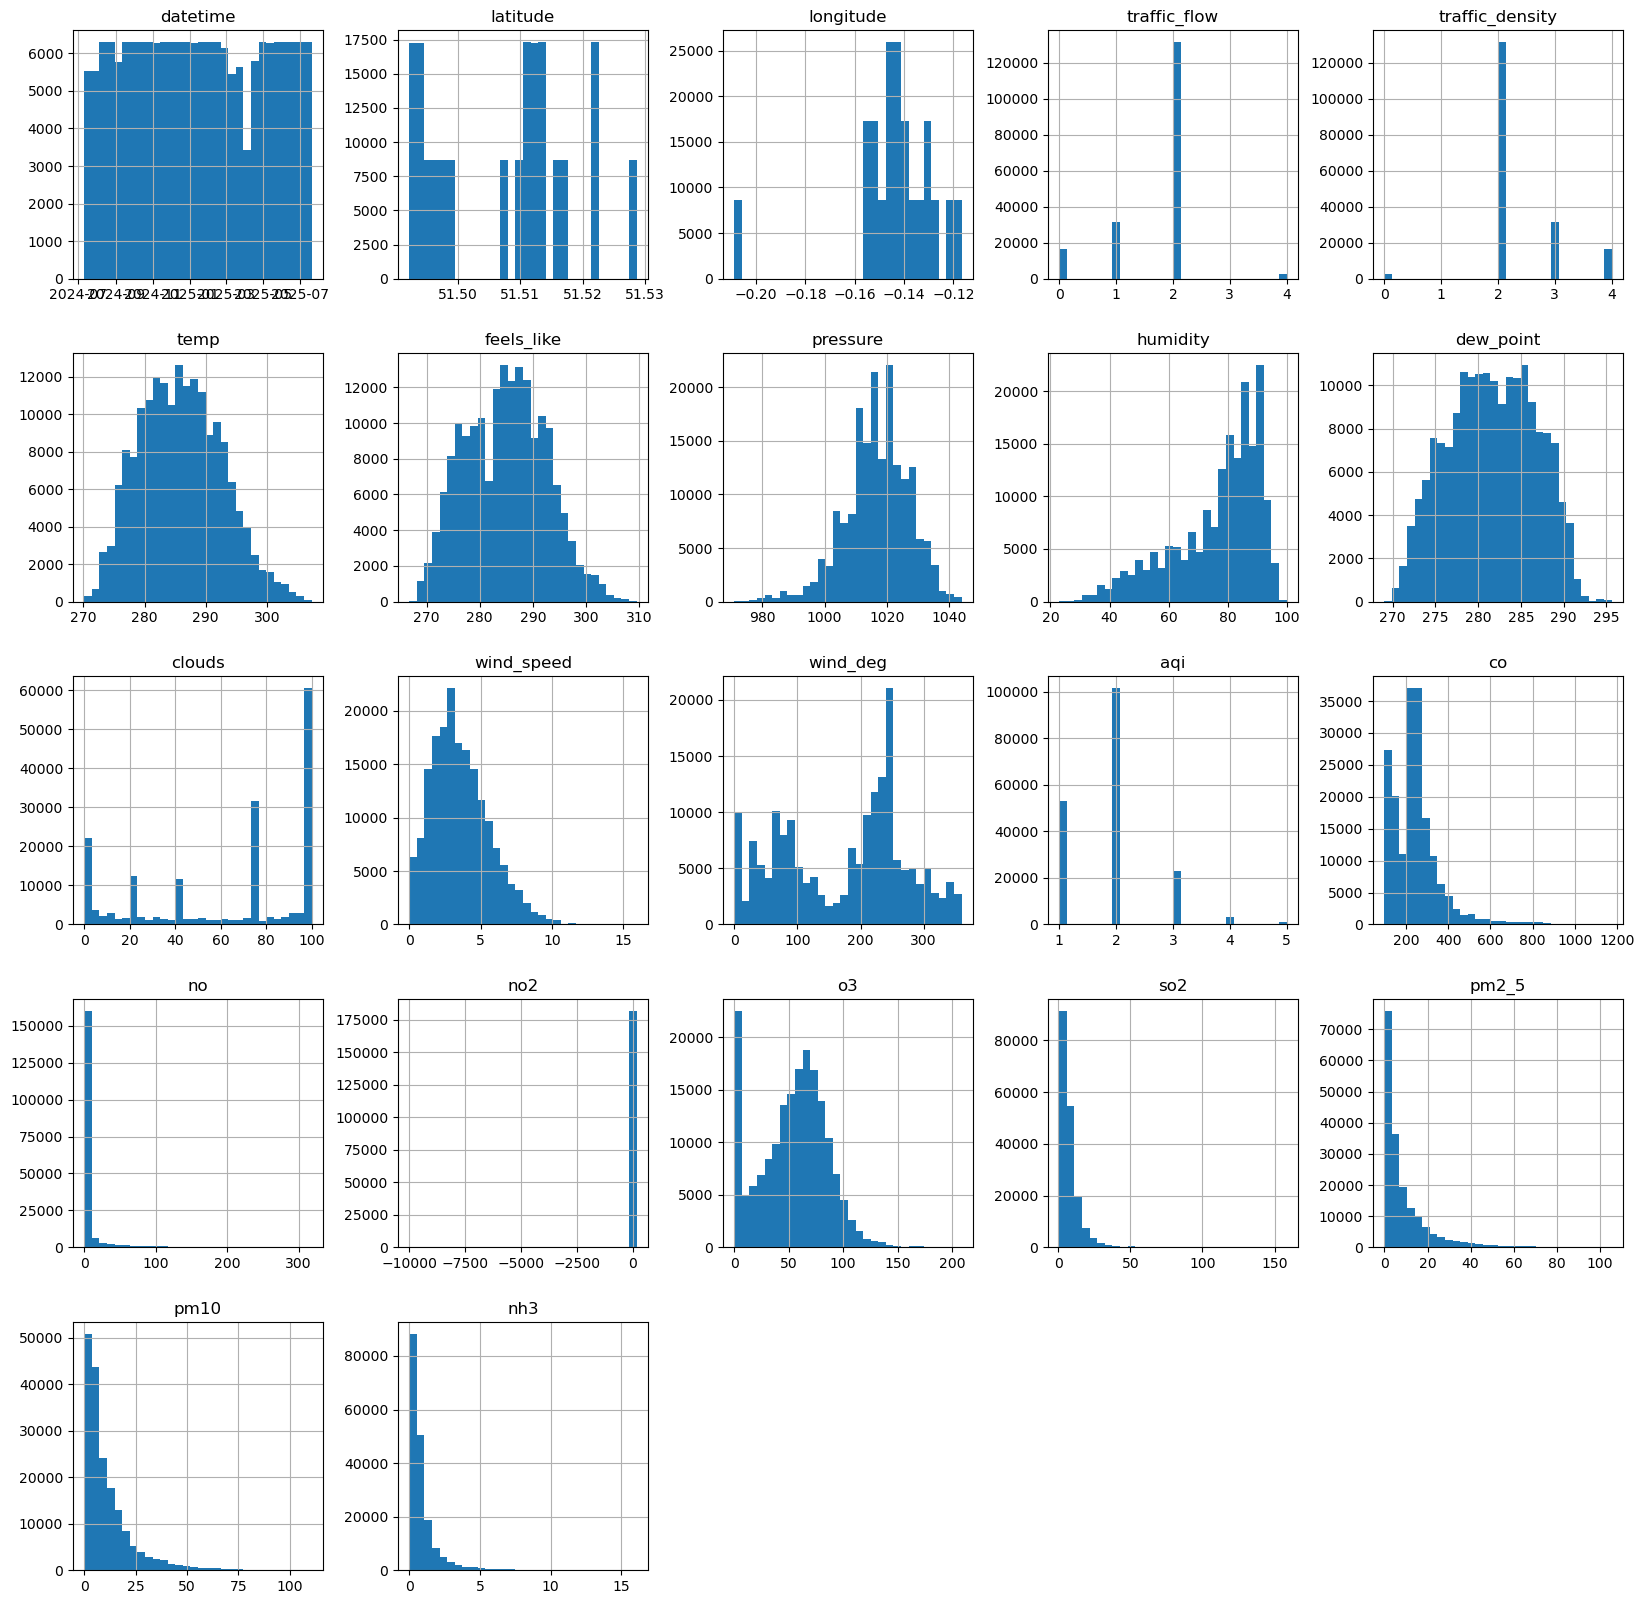

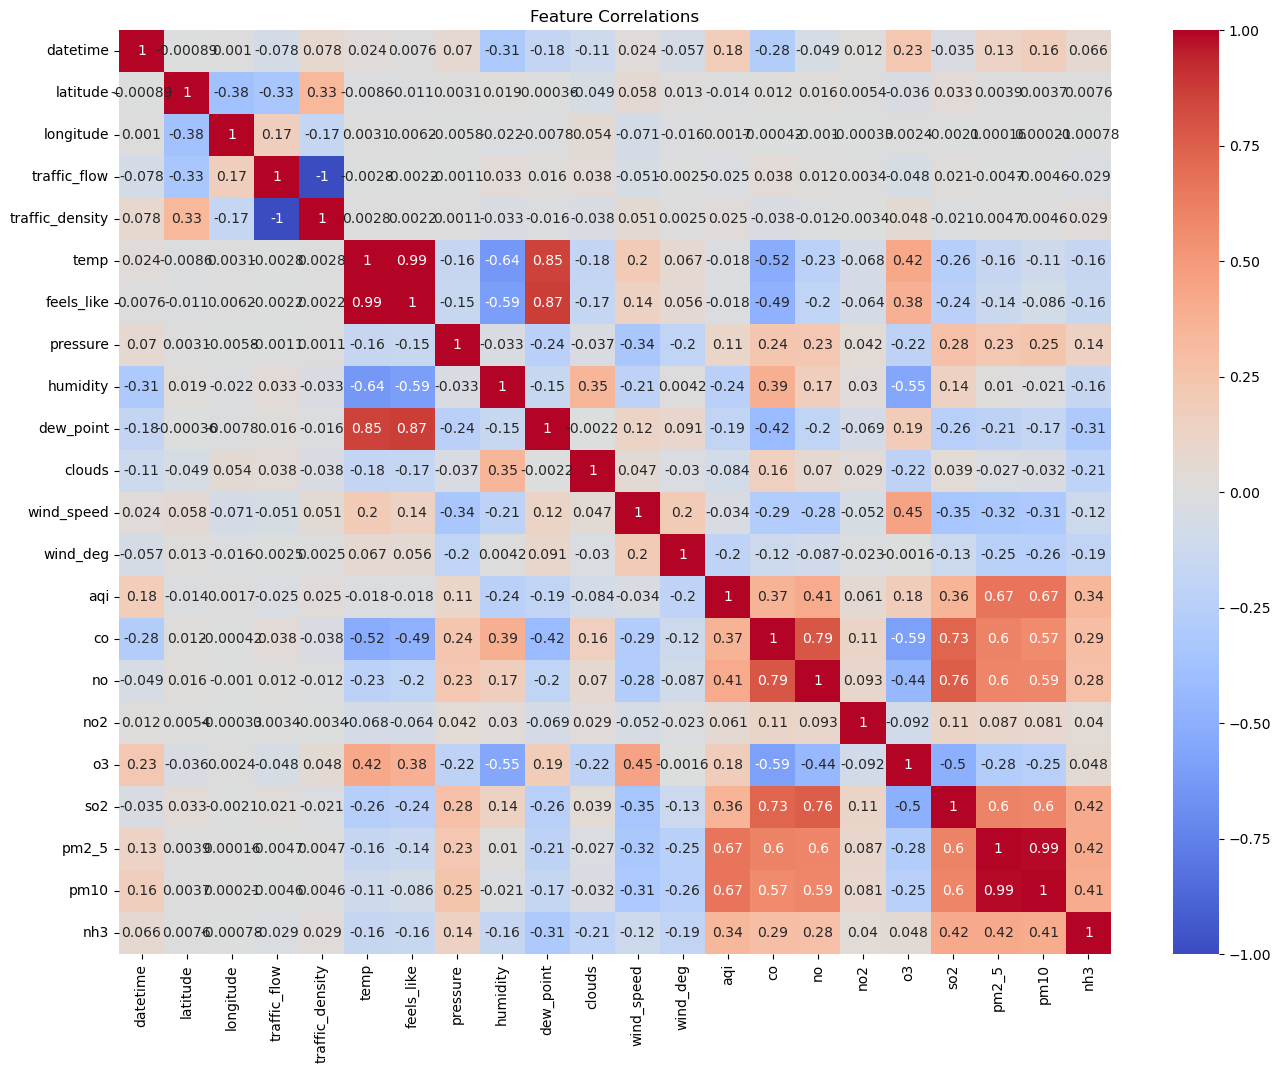

In [9]:
# Missing values
print(df.isnull().sum())

# Drop columns with most nulls
df = df.drop(['visibility', 'uvi'], axis=1)

#check null removed
# Missing values
print(df.isnull().sum())

# Numeric columns for analysis
numeric_cols = ['datetime', 'latitude', 'longitude','traffic_flow', 'traffic_density','temp', 'feels_like',
                'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg',
                'aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

# Histograms
df[numeric_cols].hist(figsize=(20, 20), bins=30)
plt.show()

# Correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlations")
plt.show()


#### * Step 5: Encode Categorical Columns

In [11]:
# Encode site_code and site_type
le_site = LabelEncoder()
df['site_code_enc'] = le_site.fit_transform(df['site_code'])

le_type = LabelEncoder()
df['site_type_enc'] = le_type.fit_transform(df['site_type'])

#### Step 6: Feature Engineering

In [13]:
# Temporal features
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].dt.weekday

#### Step 7: Define Features and Targets

In [15]:
# Features: only site_code, latitude, longitude, datetime-derived features
features = [
    'site_code_enc', 'latitude', 'longitude',
    'hour', 'day', 'month', 'weekday',
    'traffic_flow', 'traffic_density',
    'temp', 'feels_like', 'pressure', 'humidity', 'dew_point', 'clouds', 'wind_speed', 'wind_deg'
]

# Regression targets
regression_targets = ['aqi', 'co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3']

#### Step 8: Split Data into training and test

In [17]:
# Features
X = df[features]

# Regression labels
y_reg = df[regression_targets]

# Train-test split (time-based, shuffle)
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, shuffle=True
)

#### Step 9: Feature Scaling

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
scaler_path = os.path.join(MODEL_DIR, "scaler.joblib")
joblib.dump(scaler, scaler_path)
print(f"✅ Saved scaler: {scaler_path}")

✅ Saved scaler: ./forecast_model\scaler.joblib


#### Step 10: Regression Modeling train and predict with performance plots

✅ Saved model: ./forecast_model\model_regression_aqi.json
=== aqi ===
RMSE: 0.36669726208390924
MAE: 0.28313112913644223
R2: 0.7403395418775933


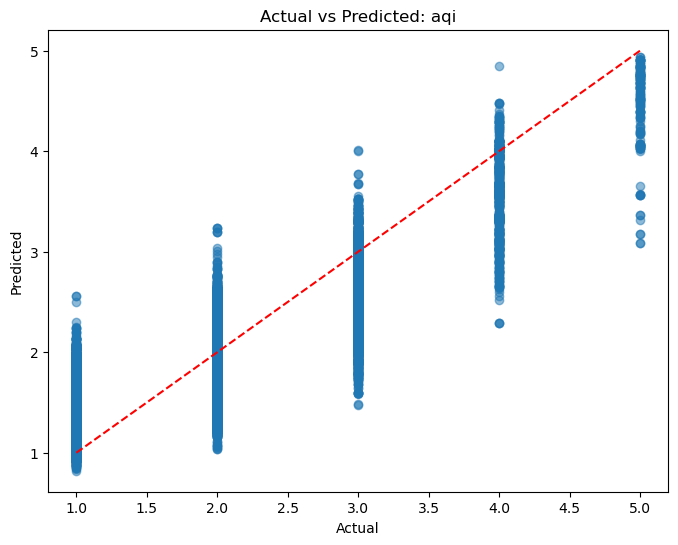

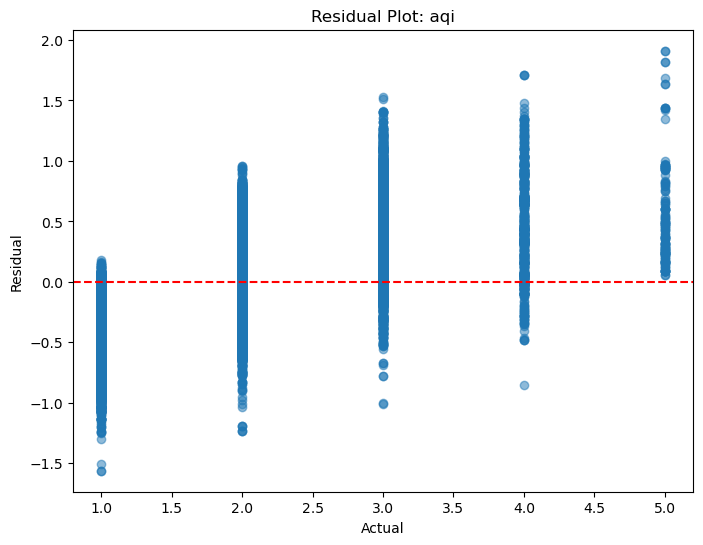

✅ Saved model: ./forecast_model\model_regression_co.json
=== co ===
RMSE: 31.08745084136431
MAE: 18.436729928238034
R2: 0.9315357922592773


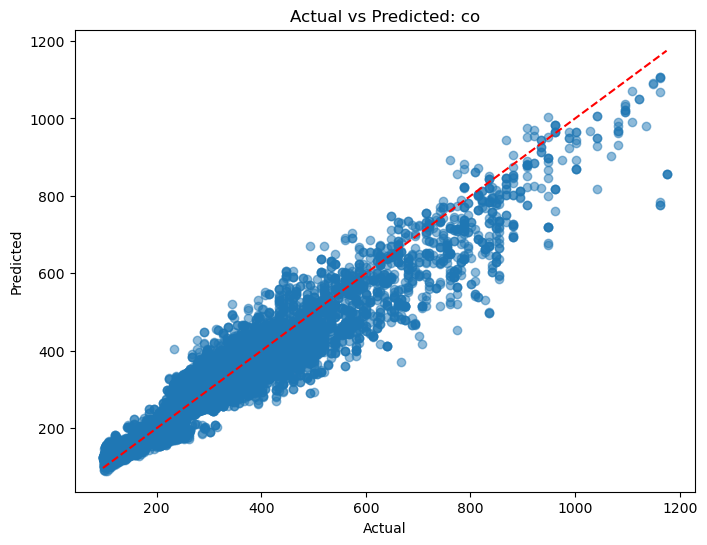

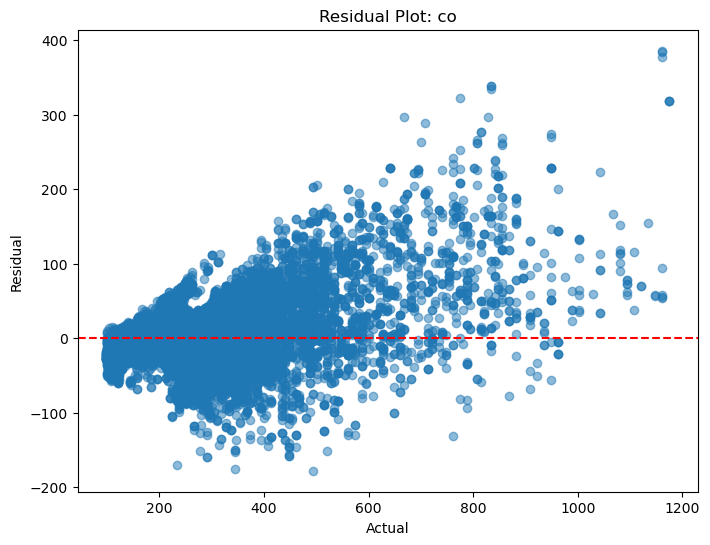

✅ Saved model: ./forecast_model\model_regression_no.json
=== no ===
RMSE: 9.494921152859519
MAE: 4.125451329890947
R2: 0.8836211111273862


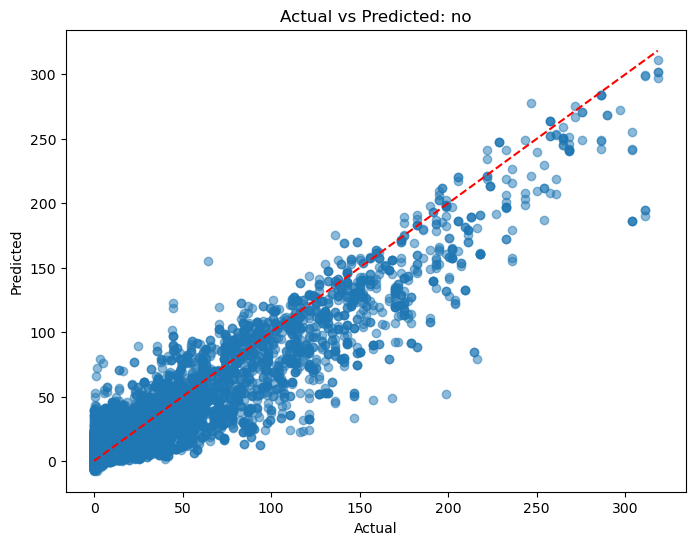

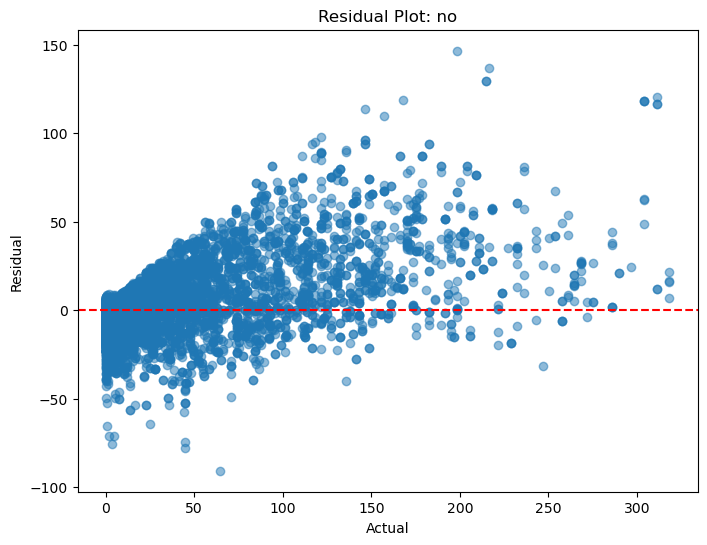

✅ Saved model: ./forecast_model\model_regression_no2.json
=== no2 ===
RMSE: 15.141614753255379
MAE: 5.329016754757474
R2: 0.9909293335574818


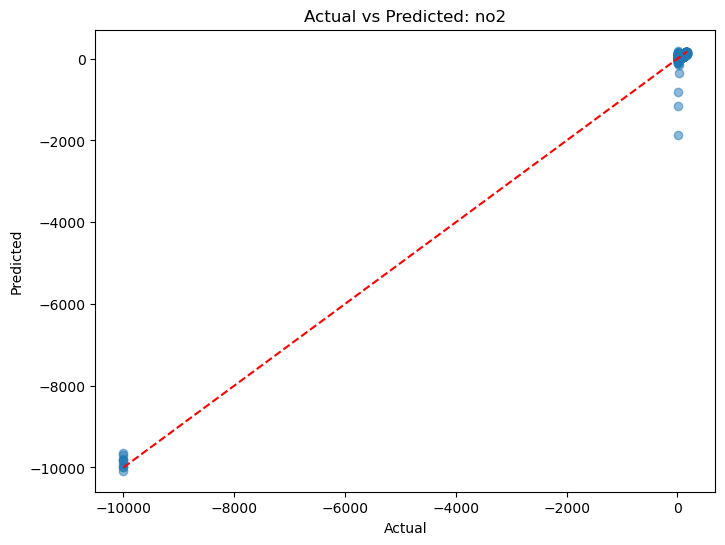

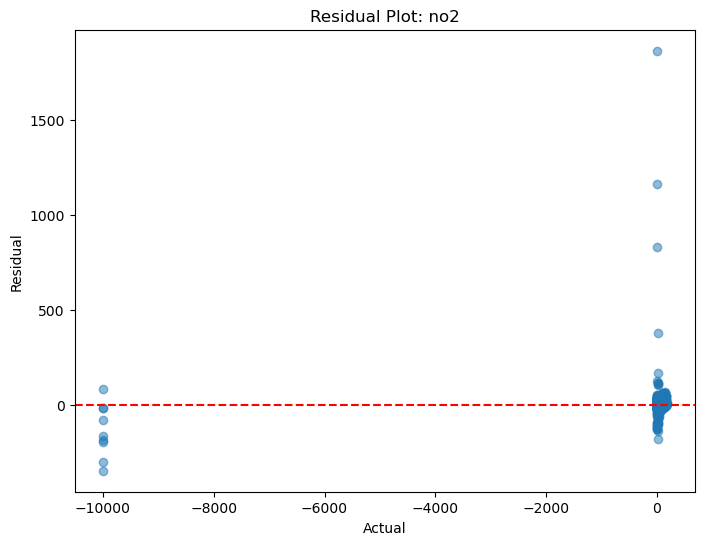

✅ Saved model: ./forecast_model\model_regression_o3.json
=== o3 ===
RMSE: 10.852764734124959
MAE: 8.190396225482804
R2: 0.878892338321313


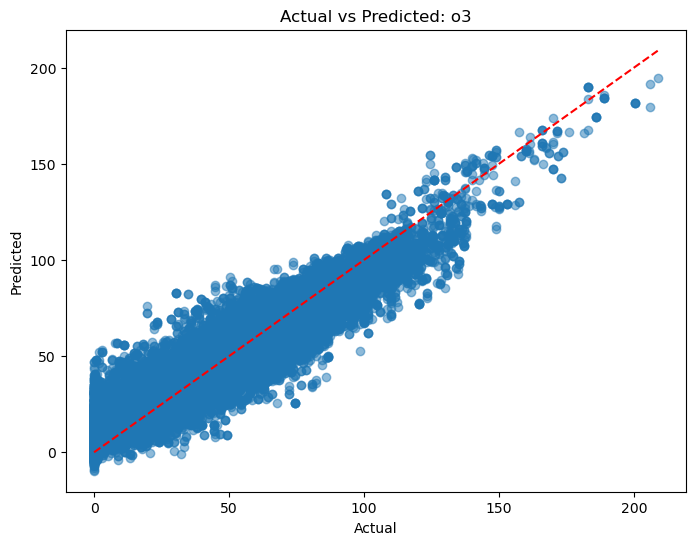

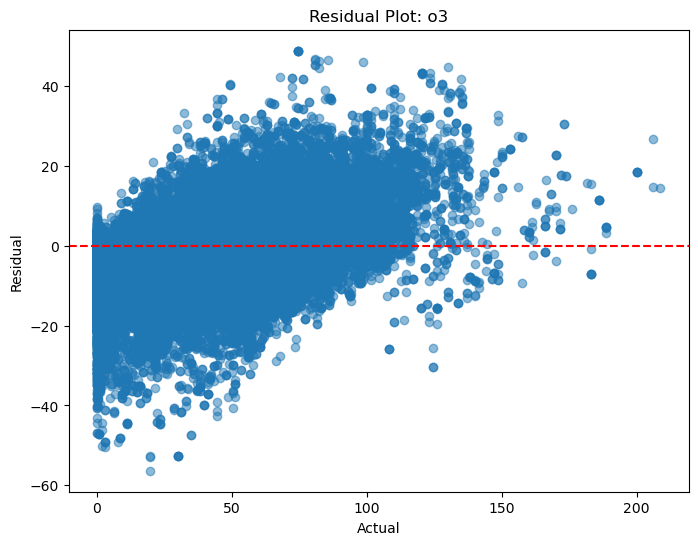

✅ Saved model: ./forecast_model\model_regression_so2.json
=== so2 ===
RMSE: 3.284661717620278
MAE: 1.8987847408904757
R2: 0.8684158937866142


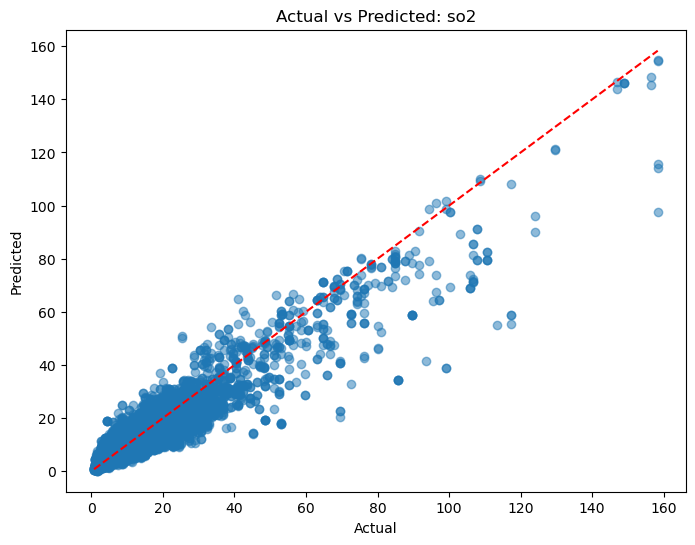

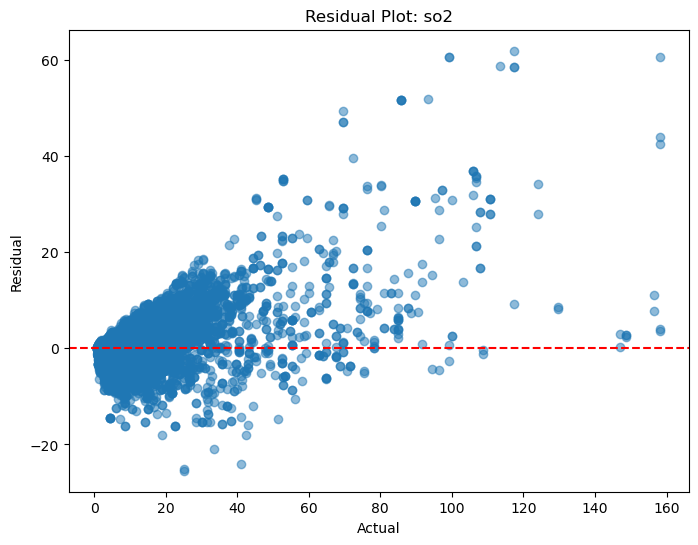

✅ Saved model: ./forecast_model\model_regression_pm2_5.json
=== pm2_5 ===
RMSE: 3.889997507718309
MAE: 2.468377180235689
R2: 0.9001928547342098


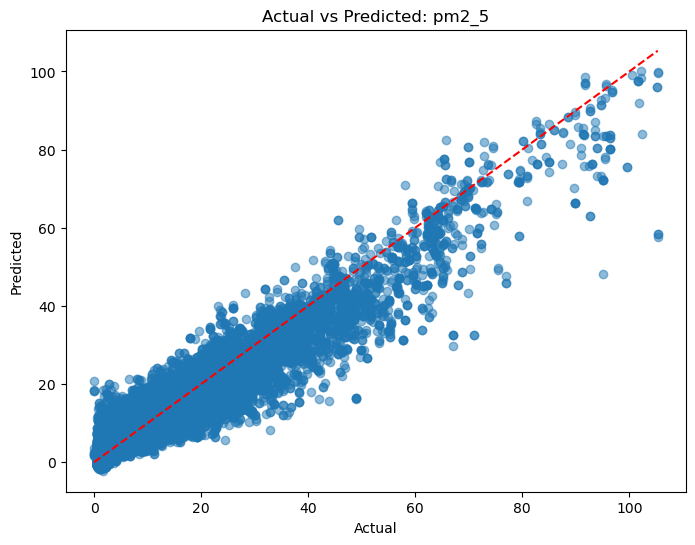

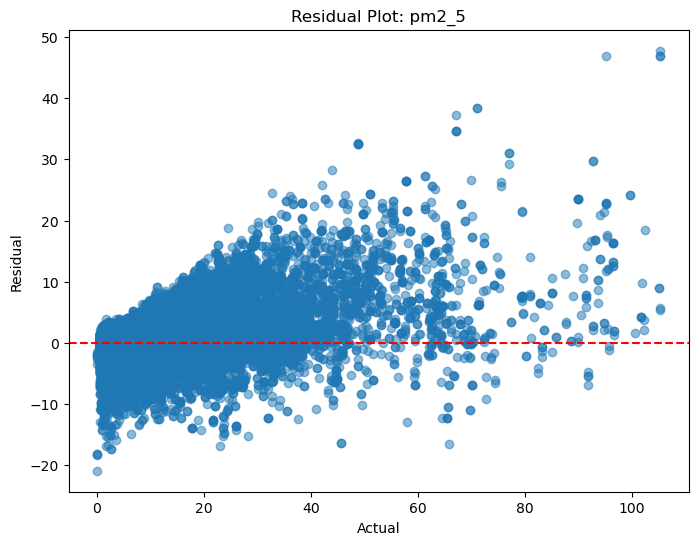

✅ Saved model: ./forecast_model\model_regression_pm10.json
=== pm10 ===
RMSE: 4.361104233377872
MAE: 2.860368079748517
R2: 0.8852018338280463


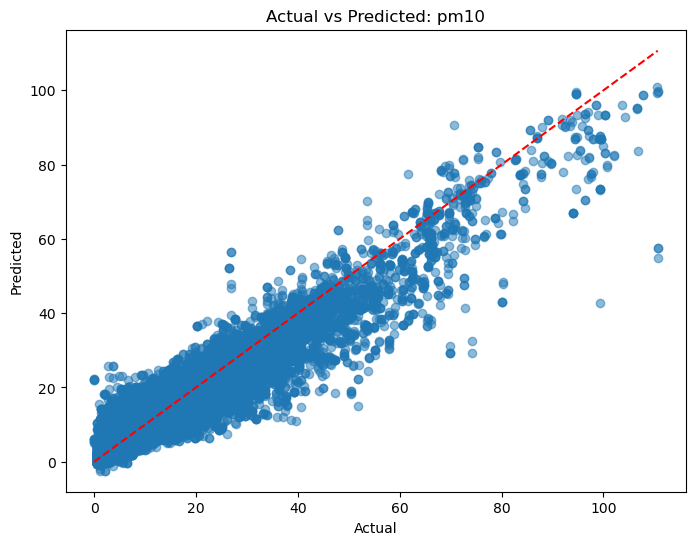

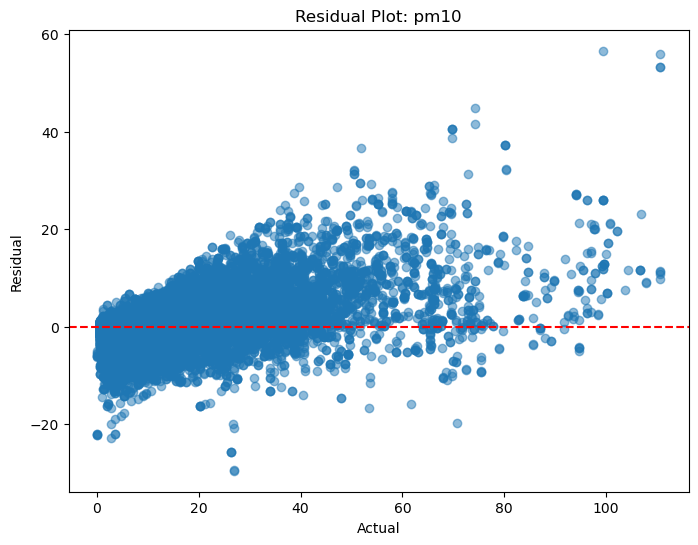

✅ Saved model: ./forecast_model\model_regression_nh3.json
=== nh3 ===
RMSE: 0.4212499415158437
MAE: 0.2435435680487011
R2: 0.8841140003331558


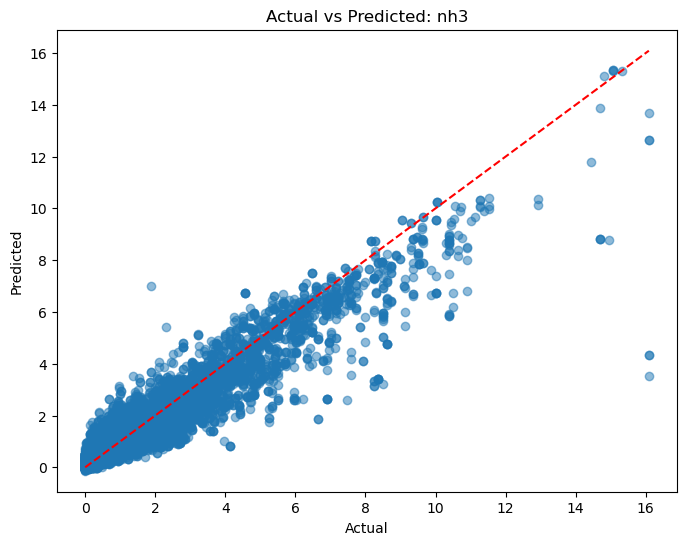

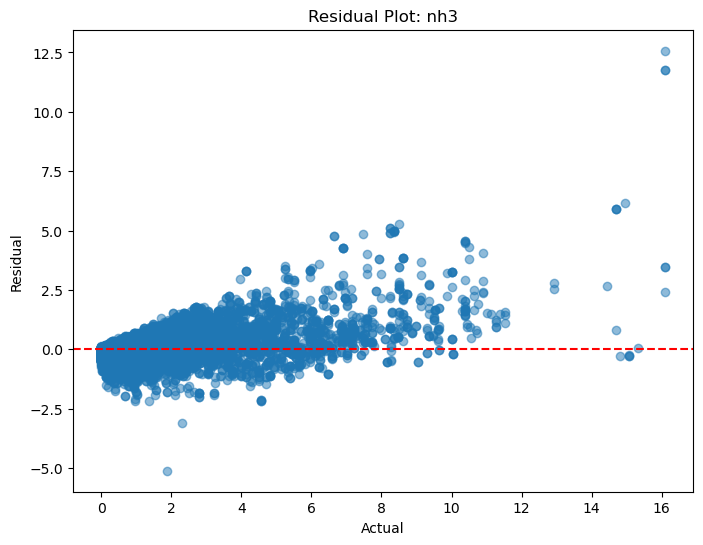

In [21]:
regression_preds = pd.DataFrame(index=y_reg_test.index)
regression_models = {}

for col in regression_targets:
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    model.fit(X_train_scaled, y_reg_train[col])

    model_path = os.path.join(MODEL_DIR, f"model_regression_{col}.json")
    model.save_model(model_path)
    print(f"✅ Saved model: {model_path}")

    y_pred = model.predict(X_test_scaled)
    regression_preds[col] = y_pred
    regression_models[col] = model

    print(f"=== {col} ===")
    print("RMSE:", np.sqrt(mean_squared_error(y_reg_test[col], y_pred)))
    print("MAE:", mean_absolute_error(y_reg_test[col], y_pred))
    print("R2:", r2_score(y_reg_test[col], y_pred))

    # --- Actual vs Predicted Plot ---
    plt.figure(figsize=(8, 6))
    plt.scatter(y_reg_test[col], regression_preds[col], alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Actual vs Predicted: {col}")
    plt.plot([y_reg_test[col].min(), y_reg_test[col].max()], [y_reg_test[col].min(), y_reg_test[col].max()], 'r--')
    plt.show()

    # --- Residual Plot ---
    residuals = y_reg_test[col] - regression_preds[col]
    plt.figure(figsize=(8, 6))
    plt.scatter(y_reg_test[col], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Actual")
    plt.ylabel("Residual")
    plt.title(f"Residual Plot: {col}")
    plt.show()